(2148, 1052, 3)


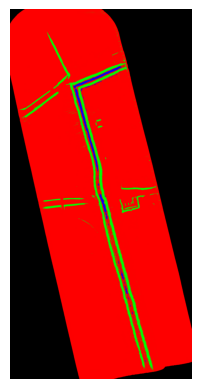

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = 'data/class_epoch_79.png'
img = cv2.imread(img_path)
img = img[:,:,::-1]

print(img.shape)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

20


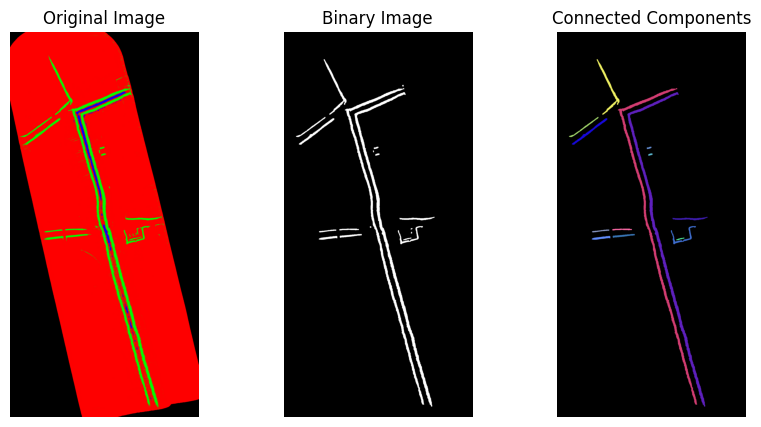

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

# Crear una máscara binaria para detectar píxeles con color verde puro
# En este caso, asumimos que un píxel es verde puro si su canal verde es mayor que los canales rojo y azul
green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
binary_img = green_mask.astype(np.uint8) * 255

# Aplicar filtro mediano para reducir ruido
binary_img = cv2.medianBlur(binary_img, 3)

# Operaciones morfológicas para eliminar líneas delgadas
kernel = np.ones((3,3), np.uint8)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, 
                             kernel, iterations=2)

# Cierre para rellenar pequeños agujeros
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, 
                             kernel, iterations=1)

# Realizar el análisis de conectividad de píxeles
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

# Crear un mapa de colores para visualizar los componentes conectados
colored_labels = np.zeros_like(img) 
for i in range(1, num_labels):
    mask = labels == i
    if img[mask].shape[0] > 150:
        colored_labels[mask] = [np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)]

# Display the original image, the binary image, and the colored labels
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(binary_img, cmap='gray')
axs[1].set_title('Binary Image')
axs[1].axis('off')

axs[2].imshow(colored_labels)
axs[2].set_title('Connected Components')
axs[2].axis('off')

print(num_labels)
plt.show()

[1, 3, 4, 5, 6, 7, 9, 10, 11, 14, 15, 17, 18, 19]


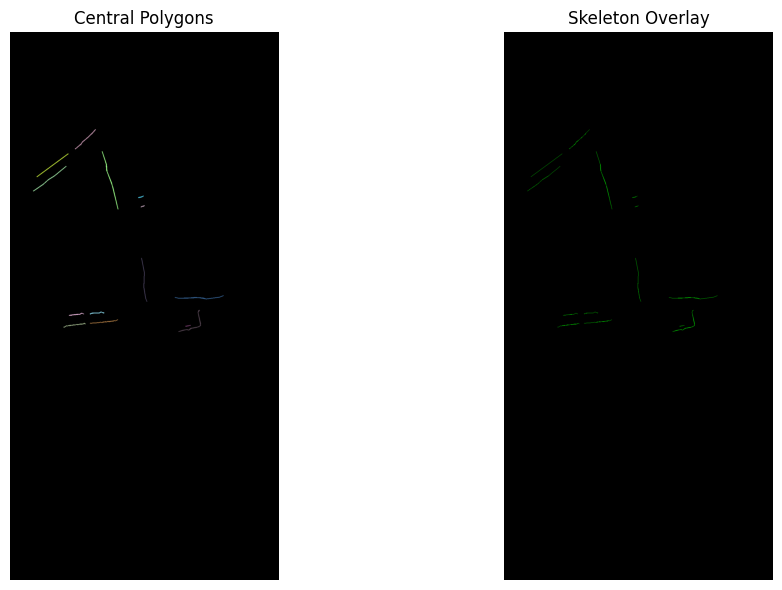

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fast_thinning(img):
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    while True:
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = img - open
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

# Operaciones morfológicas optimizadas
binary_img = cv2.medianBlur(binary_img, 3)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

# Análisis de conectividad con filtrado temprano
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

print(valid_components)

# Pre-alocar arrays
colored_labels = np.zeros_like(img)
skeleton_overlay = colored_labels.copy()

# Procesar solo componentes válidos
for i in valid_components:
    mask = (labels == i).astype(np.uint8)
    
    # Extraer ROI para procesamiento local
    x, y, w, h = cv2.boundingRect(mask)
    roi = mask[y:y+h, x:x+w]
    
    # Skeletonización optimizada
    skeleton = fast_thinning(roi)
    
    # Encontrar contorno principal
    contours = cv2.findContours(skeleton, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    if not contours:
        continue
    
    # Encontrar el contorno más largo
    main_contour = max(contours, key=lambda x: cv2.arcLength(x, False))
    
    # Aproximación poligonal adaptativa
    epsilon = 0.005 * cv2.arcLength(main_contour, True)
    polygon = cv2.approxPolyDP(main_contour, epsilon, True)
    
    # Escalar coordenadas a la imagen original
    polygon = polygon + (x, y)
    
    # Dibujar resultados
    color = [np.random.randint(50, 256) for _ in range(3)]
    cv2.drawContours(colored_labels, [polygon], -1, color, 2)
    cv2.polylines(skeleton_overlay, [polygon], False, (0,255,0), 1)

# Visualización optimizada
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(colored_labels, cv2.COLOR_BGR2RGB))
plt.title('Central Polygons'), plt.axis('off')

plt.subplot(122), plt.imshow(cv2.cvtColor(skeleton_overlay, cv2.COLOR_BGR2RGB))
plt.title('Skeleton Overlay'), plt.axis('off')

plt.tight_layout()
plt.show()